# Sentiment Classifier Web Application (English & Indonesian Version)

---
\\

This notebook contains the data preprocessing and model developing (structuring and training the deep learning model) part of the sentiment classifier web application. For both language versions, the data preprocessing steps include sentence tokenization and padding, resulting in 2 tokenizers, one for each language. The libraries or dependencies used in building this application are: \\

1. Pandas
2. Numpy
3. TensorFlow
4. Matplotlib & Seaborn
5. Huggingface Datasets (for Indonesian version only).

\\

IMDB reviews of the TensorFlow Datasets was used to train the model of English version. Meanwhile, indonlp/indonlu (https://huggingface.co/datasets/indonlp/indonlu) was used to train the model of Indonesian version. Later on, the trained model will be deployed as a web application using streamlit (front-end) and github (back-end).

# Import Libraries

The libraries mentioned before were installed and imported in this section

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import io
import json
from datasets import load_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# English Version

## Import Files & Some Checking

As stated before, the English version will use IMDB reviews data from the tensorflow datasets library. Therefore, the data is imported in this section. After that, there will be some additional checking to know a little bit more about the data.

In [ ]:
# Load the initial data from tensorflow datasets
data = tfds.load("imdb_reviews", with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS5D9V9/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS5D9V9/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS5D9V9/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Split the data into train and test sets
train_data = data['train']
test_data = data['test']

In [ ]:
# Store the texts and labels of train set into their respective arrays
train_texts = []
train_labels = []

for text, label in train_data:
  train_texts.append(text.numpy().decode('utf-8'))
  train_labels.append(label.numpy())

In [ ]:
# Store the texts and labels of test set into their respective arrays
test_texts = []
test_labels = []

for text, label in test_data:
  test_texts.append(text.numpy().decode('utf-8'))
  test_labels.append(label.numpy())

In [ ]:
# Convert the train_labels and test_labels arrays into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
# Check one of the text content
test_texts[:1]

["There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."]

In [ ]:
# Check one of the label
test_labels[:1]

array([1])

In [ ]:
# Convert the train and test data into pandas dataframe
df_train = pd.DataFrame({'text': train_texts, 'label': train_labels})
df_test = pd.DataFrame({'text': test_texts, 'label': test_labels})

In [ ]:
# Add the length column for both df_train and df_test
df_train['length'] = df_train['text'].apply(lambda row: len(row))
df_test['length'] = df_test['text'].apply(lambda row: len(row))

In [ ]:
# Check some stats :)
print('Stats for df_train:')
print()
print(df_train['length'].describe())
print()
print('Stats for df_test:')
print()
print(df_test['length'].describe())

Stats for df_train:

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: length, dtype: float64

Stats for df_test:

count    25000.00000
mean      1293.79240
std        975.90776
min         32.00000
25%        696.00000
50%        962.00000
75%       1572.00000
max      12988.00000
Name: length, dtype: float64


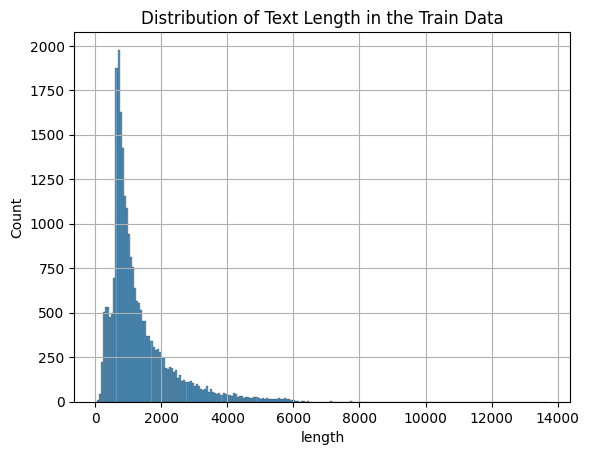

In [ ]:
# View the distribution of text length in the train data
sns.histplot(df_train['length'])
plt.grid()
plt.title('Distribution of Text Length in the Train Data')
plt.show()

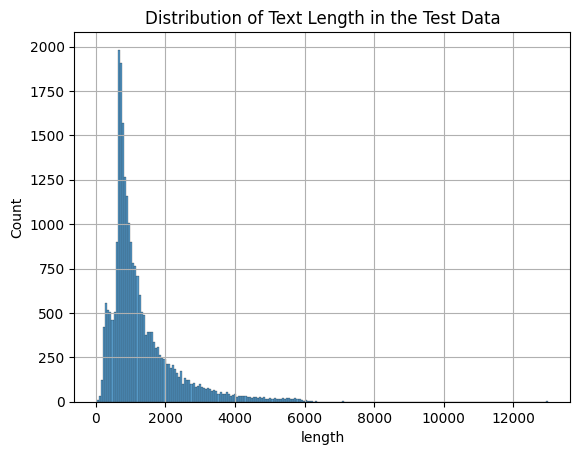

In [ ]:
# View the distribution of text length in the test data
sns.histplot(df_test['length'])
plt.grid()
plt.title('Distribution of Text Length in the Test Data')
plt.show()

## Tokenizer and Padding

Here is the section for preprocessing the texts, which consists of tokenizing and padding the texts.

### Tokenizer

In [ ]:
# Define the tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')

# Fit the tokenizer into the training texts
tokenizer.fit_on_texts(train_texts)

In [ ]:
# Transform the training and test texts into sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

### Hyperparameters

In [ ]:
# Define some hyperparameters for the model
max_length = 2000
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64

### Padding

In [ ]:
# Pad the sequences
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

## Model

The maximum allowed size for a file to be stored in GitHub is 100mb, so the model must be as simple as possible to fulfill the 100mb requirement. The model used in this project consisted of the combination of GlobalAveragePooling1D, and some Dropout and Dense layers.

In [ ]:
from keras import backend as K

In [ ]:
# To clear the session
K.clear_session()

In [ ]:
# The function below will define the model architecture, compile, and train it.
def sentiment_analysis_model(epochs=10):

  # Define the model architecture
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dropout(0.6),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(units=1, activation='sigmoid')
      ])

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  # Train the model
  model.fit(x=train_sequences, y=train_labels, validation_data=(test_sequences, test_labels), epochs=epochs)

  return model

In [ ]:
model = sentiment_analysis_model(epochs=5)

Epoch 1/5
782/782 [==============================] - 127s 160ms/step - loss: 0.6596 - accuracy: 0.5718 - val_loss: 0.4285 - val_accuracy: 0.8260
Epoch 2/5
782/782 [==============================] - 60s 77ms/step - loss: 0.3228 - accuracy: 0.8726 - val_loss: 0.2921 - val_accuracy: 0.8804
Epoch 3/5
782/782 [==============================] - 30s 39ms/step - loss: 0.2205 - accuracy: 0.9190 - val_loss: 0.2805 - val_accuracy: 0.8866
Epoch 4/5
782/782 [==============================] - 28s 36ms/step - loss: 0.1724 - accuracy: 0.9376 - val_loss: 0.3396 - val_accuracy: 0.8736
Epoch 5/5
782/782 [==============================] - 20s 26ms/step - loss: 0.1337 - accuracy: 0.9552 - val_loss: 0.3229 - val_accuracy: 0.8839


In [ ]:
# save the model
model.save('/content/drive/MyDrive/Personal Projects/Sentiment Analysis')

In [ ]:
# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with io.open('/content/drive/MyDrive/Personal Projects/Sentiment Analysis/tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## Load Model

This section is used to develop the user's flow on the web (from loading the model, receiving user's input, to predict and return the result to user).

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Personal Projects/Sentiment Analysis')

In [ ]:
# Load the tokenizer
with open('/content/drive/MyDrive/Personal Projects/Sentiment Analysis/tokenizer.json') as f:
  data = json.load(f)
  tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [ ]:
sample_text = "I just watched the latest movie, and I absolutely loved it! The acting was superb, and the storyline kept me engaged from start to finish. I can't wait to see it again."

In [ ]:
def model_prediction(input_text):

  # Tokenize the text
  x = tokenizer.texts_to_sequences([input_text])

  # Pad the tokenized text
  x = pad_sequences(x, maxlen=2000, padding='post', truncating='post')

  # Predict the sentiment of the converted text
  result = model.predict(x)

  # Return the result
  return result

In [ ]:
test_result = model_prediction(sample_text)

1/1 [==============================] - 0s 29ms/step


In [ ]:
test_result

array([[0.9583805]], dtype=float32)

# Indonesian Version

As stated before, the Indonesian version will use indonlp/indonlu data from the Huggingface datasets library (https://huggingface.co/datasets/indonlp/indonlu). Therefore, the data is imported in this section. After that, there will be some additional checking to know a little bit more about the data.

In [ ]:
# Load the dataset from huggingface hub
dataset = load_dataset("indonlp/indonlu", "smsa")

Generating train split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Get the overview of the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [ ]:
# Save all the data into their respectives list
train_texts = [text for text in dataset['train']['text']]
validation_texts = [text for text in dataset['validation']['text']]
test_texts = [text for text in dataset['test']['text']]

train_labels = [label for label in dataset['train']['label']]
validation_labels = [label for label in dataset['validation']['label']]
test_labels = [label for label in dataset['test']['label']]

In [ ]:
# Apply np.array into each labels list
indonesian_train_labels = np.array(train_labels)
indonesian_validation_labels = np.array(validation_labels)
indonesian_ktest_labels = np.array(test_labels)

In [ ]:
# Save into the pandas dataframe format
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
validation_df = pd.DataFrame({'text': validation_texts, 'label': validation_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

In [ ]:
# Get the length of each text
train_df['length'] = train_df['text'].apply(lambda row: len(row))
validation_df['length'] = validation_df['text'].apply(lambda row: len(row))
test_df['length'] = test_df['text'].apply(lambda row: len(row))

In [ ]:
# Check some stats
print('Stats for train_df:')
print(train_df['length'].describe())
print()
print('Stats for validation_df:')
print(validation_df['length'].describe())
print()
print('Stats for test_df:')
print(test_df['length'].describe())

Stats for train_df:
count    11000.000000
mean       188.896909
std        121.082093
min          3.000000
25%         89.000000
50%        160.000000
75%        276.000000
max        567.000000
Name: length, dtype: float64

Stats for validation_df:
count    1260.000000
mean      186.115079
std       119.315603
min         4.000000
25%        91.000000
50%       156.000000
75%       270.000000
max       554.000000
Name: length, dtype: float64

Stats for test_df:
count    500.000000
mean     142.074000
std       82.667214
min       21.000000
25%       74.750000
50%      123.000000
75%      193.250000
max      477.000000
Name: length, dtype: float64


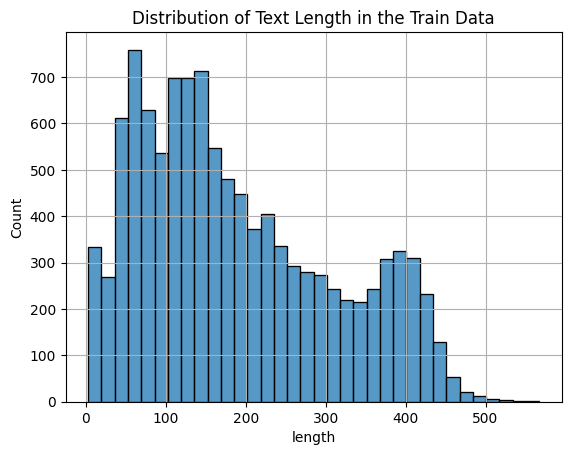

In [ ]:
# View the distribution of text length in the train data
sns.histplot(train_df['length'])
plt.grid()
plt.title('Distribution of Text Length in the Train Data')
plt.show()

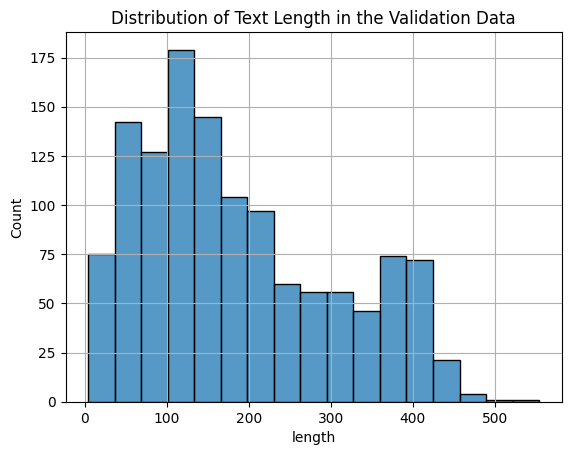

In [ ]:
# View the distribution of text length in the train data
sns.histplot(validation_df['length'])
plt.grid()
plt.title('Distribution of Text Length in the Validation Data')
plt.show()

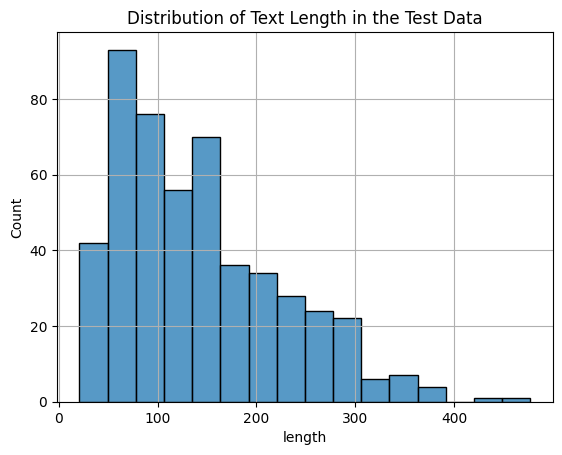

In [ ]:
# View the distribution of text length in the train data
sns.histplot(test_df['length'])
plt.grid()
plt.title('Distribution of Text Length in the Test Data')
plt.show()

## Tokenizer and Padding

Here is the section for preprocessing the texts, which consists of tokenizing and padding the texts.

### Tokenizer

In [ ]:
# Define the tokenizer
indonesian_tokenizer = Tokenizer(oov_token='<OOV>')

In [ ]:
# Fit the tokenizer into the train texts
indonesian_tokenizer.fit_on_texts(train_texts)

In [ ]:
# Apply the tokenizer into the train and validation texts
indonesian_train_texts = indonesian_tokenizer.texts_to_sequences(train_texts)
indonesian_validation_texts = indonesian_tokenizer.texts_to_sequences(validation_texts)

### Hyperparameters

In [ ]:
# Define some hyperparameters
indonesian_max_length = 500
indonesian_vocab_size = len(indonesian_tokenizer.word_index) + 1
indonesian_embedding_dim = 90

### Padding

In [ ]:
# Pad the sequences
indonesian_train_sequences = pad_sequences(indonesian_train_texts, maxlen=indonesian_max_length, padding='post', truncating='post')
indonesian_validation_sequences = pad_sequences(indonesian_validation_texts, maxlen=indonesian_max_length, padding='post', truncating='post')

## Model

The maximum allowed size for a file to be stored in GitHub is 100mb, so the model must be as simple as possible to fulfill the 100mb requirement. The model used in this project consisted of the combination of GlobalAveragePooling1D, and some Dropout and Dense layers.

In [ ]:
from keras import backend as K

In [ ]:
# To clear the session
K.clear_session()

In [ ]:
# The function below will define the model architecture, compile, and train it.
def indonesian_sentiment_analysis_model(epochs=10):

  # Define the model architecture
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=indonesian_vocab_size, output_dim=indonesian_embedding_dim, input_length=indonesian_max_length),
      tf.keras.layers.GlobalAveragePooling1D(),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dropout(0.6),
      tf.keras.layers.Dense(units=128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(units=3, activation='softmax')
      ])

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  model.fit(x=indonesian_train_sequences, y=indonesian_train_labels, validation_data=(indonesian_validation_sequences, indonesian_validation_labels), epochs=epochs)

  return model

In [ ]:
model = indonesian_sentiment_analysis_model(epochs=8)

Epoch 1/8
344/344 [==============================] - 28s 79ms/step - loss: 0.8676 - accuracy: 0.6001 - val_loss: 0.6588 - val_accuracy: 0.7524
Epoch 2/8
344/344 [==============================] - 6s 19ms/step - loss: 0.6104 - accuracy: 0.7593 - val_loss: 0.5606 - val_accuracy: 0.7794
Epoch 3/8
344/344 [==============================] - 3s 8ms/step - loss: 0.5283 - accuracy: 0.7906 - val_loss: 0.5145 - val_accuracy: 0.7952
Epoch 4/8
344/344 [==============================] - 3s 10ms/step - loss: 0.4594 - accuracy: 0.8154 - val_loss: 0.4718 - val_accuracy: 0.8103
Epoch 5/8
344/344 [==============================] - 4s 11ms/step - loss: 0.3959 - accuracy: 0.8340 - val_loss: 0.4294 - val_accuracy: 0.8151
Epoch 6/8
344/344 [==============================] - 3s 7ms/step - loss: 0.3265 - accuracy: 0.8740 - val_loss: 0.3982 - val_accuracy: 0.8651
Epoch 7/8
344/344 [==============================] - 2s 7ms/step - loss: 0.2571 - accuracy: 0.9108 - val_loss: 0.3746 - val_accuracy: 0.8833
Epoch 8/

## Test on the Test Dataset

In [ ]:
# This function will preprocess the input text and return the model's prediction result
def indonesian_inference(input_text):
  x = indonesian_tokenizer.texts_to_sequences([input_text])
  x = pad_sequences(x, maxlen=500, padding='post', truncating='post')
  prediction = model.predict(x)
  best = np.argmax(prediction)
  return best

In [ ]:
# Check the content of the text
train_texts[0]

'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !'

In [ ]:
# Try to do the inference
indonesian_inference(train_texts[0])

1/1 [==============================] - 0s 51ms/step


0

In [ ]:
test_df

,text,label,length
0,kemarin gue datang ke tempat makan baru yang a...,2,238
1,kayak nya sih gue tidak akan mau balik lagi ke...,2,288
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",2,230
3,ini pertama kalinya gua ke bank buat ngurusin ...,2,281
4,waktu sampai dengan gue pernah disuruh ibu lat...,2,264
...,...,...,...
495,kata nya tidur yang baik itu minimal enam jam ...,1,54
496,indonesia itu ada di benua asia .,1,33
497,salah satu kegemaran anak remaja indonesia sek...,1,75
498,melihat warna hijau bisa bikin mata jadi lebih...,0,55


In [ ]:
# Apply the inference function
test_df['prediction_label'] = test_df['text'].apply(lambda row: indonesian_inference(row))

1/1 [==============================] - 0s 19ms/step


In [ ]:
# Check the resulting dataframe
test_df

,text,label,length,prediction_label
0,kemarin gue datang ke tempat makan baru yang a...,2,238,2
1,kayak nya sih gue tidak akan mau balik lagi ke...,2,288,2
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",2,230,2
3,ini pertama kalinya gua ke bank buat ngurusin ...,2,281,2
4,waktu sampai dengan gue pernah disuruh ibu lat...,2,264,2
...,...,...,...,...
495,kata nya tidur yang baik itu minimal enam jam ...,1,54,2
496,indonesia itu ada di benua asia .,1,33,1
497,salah satu kegemaran anak remaja indonesia sek...,1,75,0
498,melihat warna hijau bisa bikin mata jadi lebih...,0,55,2


In [ ]:
# Check the mean accuracy of the entire test dataset
print('Test Accuracy:', len(test_df[test_df['label'] == test_df['prediction_label']])/len(test_df) * 100)

Test Accuracy: 76.2


## Save the Tokenizer and the Model

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Personal Projects/Sentiment Analysis/Indonesian')

In [ ]:
# Save the tokenizer
indonesian_tokenizer_json = indonesian_tokenizer.to_json()
with open('/content/drive/MyDrive/Personal Projects/Sentiment Analysis/Indonesian/indonesian_tokenizer.json', 'w', encoding='utf-8') as f:
  f.write(json.dumps(indonesian_tokenizer_json, ensure_ascii=False))